# Part 6: Convolutional Neural Networks in hls4ml

In this notebook you will learn how to train a pruned and quantized convolutional neural network (CNN) and deploy it using hls4ml. For this exercise, we will use the Street View House Numbers (SVHN) Dataset (http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of real-world images of house numbers extracted from Google Street View images. The format is similar to that of the MNIST dataset, but is a much more challenging real-world problem, as illustrated by the examples shown below.

All the images are in RGB format and have been cropped to 32x32 pixels. 
Unlike MNIST, more than one digit can be present in the same image and in these cases, the center digit is used to assign a label to the image.
Each image can belong to one of 10 classes, corresponding to digits 0 through 9.

![alt text](images/test.png "SVHN examples from the test dataset")

The SVHN dataset consists of 73,257 images for training (and 531,131 extra samples that are easier to classify and can be used as additional training data) and 26,032 images for testing.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

2024-02-27 21:08:00.602356: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 21:08:00.933719: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 21:08:00.933765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 21:08:00.935842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 21:08:01.116061: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-27 21:08:01.117798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Fetch the SVHN dataset using Tensorflow Dataset

Training on 73257 samples of input shape (32, 32, 3), belonging to 10 classes


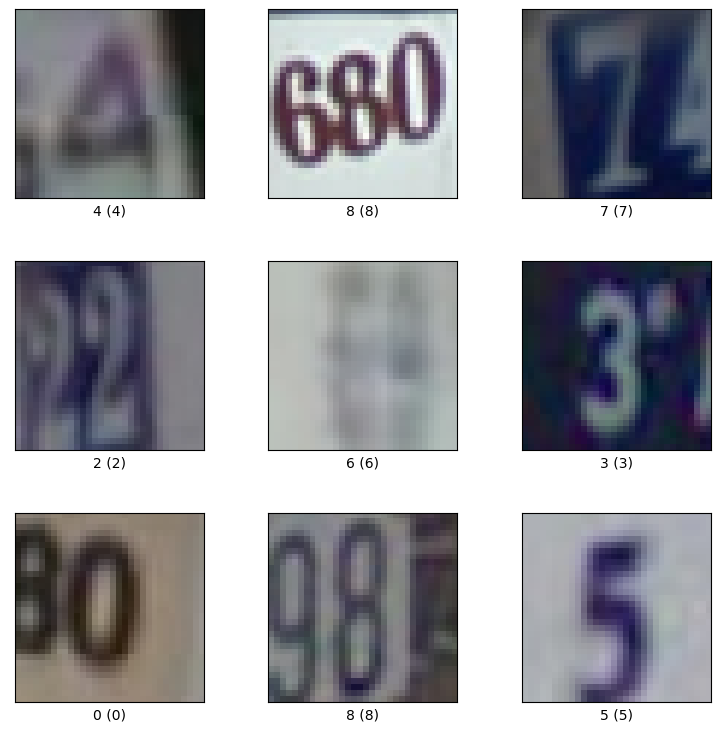

In [2]:
ds_train, info = tfds.load('svhn_cropped', split='train[:90%]', with_info=True, as_supervised=True)
ds_test = tfds.load('svhn_cropped', split='test', shuffle_files=True, as_supervised=True)
ds_val = tfds.load('svhn_cropped', split='train[-10%:]', shuffle_files=True, as_supervised=True)

assert isinstance(ds_train, tf.data.Dataset)
train_size = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape
n_classes = info.features['label'].num_classes

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size, input_shape, n_classes))
fig = tfds.show_examples(ds_train, info)

In [3]:
def preprocess(image, label, nclasses=10):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.one_hot(tf.squeeze(label), nclasses)
    return image, label

In [4]:
batch_size = 1024

train_data = ds_train.map(preprocess, n_classes)  # Get dataset as image and one-hot encoded labels, divided by max RGB
train_data = train_data.shuffle(4096).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for example in train_data.take(1):
    break
print("X train batch shape = {}, Y train batch shape = {} ".format(example[0].shape, example[1].shape))

val_data = ds_val.map(preprocess, n_classes)
val_data = val_data.batch(batch_size)
val_data = val_data.prefetch(tf.data.experimental.AUTOTUNE)

# For  testing, we get the full dataset in memory as it's rather small.
# We fetch it as numpy arrays to have access to labels and images separately
X_test, Y_test = tfds.as_numpy(tfds.load('svhn_cropped', split='test', batch_size=-1, as_supervised=True))
X_test, Y_test = preprocess(X_test, Y_test, nclasses=n_classes)
print("X test batch shape = {}, Y test batch shape = {} ".format(X_test.shape, Y_test.shape))

X train batch shape = (1024, 32, 32, 3), Y train batch shape = (1024, 10) 
X test batch shape = (26032, 32, 32, 3), Y test batch shape = (26032, 10) 


In [5]:
import pickle

# with open('train_data.bin', 'wb') as tr_f:
#     pickle.dump(train_data, tr_f)

train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

## Defining the model

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv_0 (Conv2D)             (None, 30, 30, 16)        432       
                                                                 
 bn_conv_0 (BatchNormalizat  (None, 30, 30, 16)        64        
 ion)                                                            
                                                                 
 conv_act_0 (Activation)     (None, 30, 30, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (N

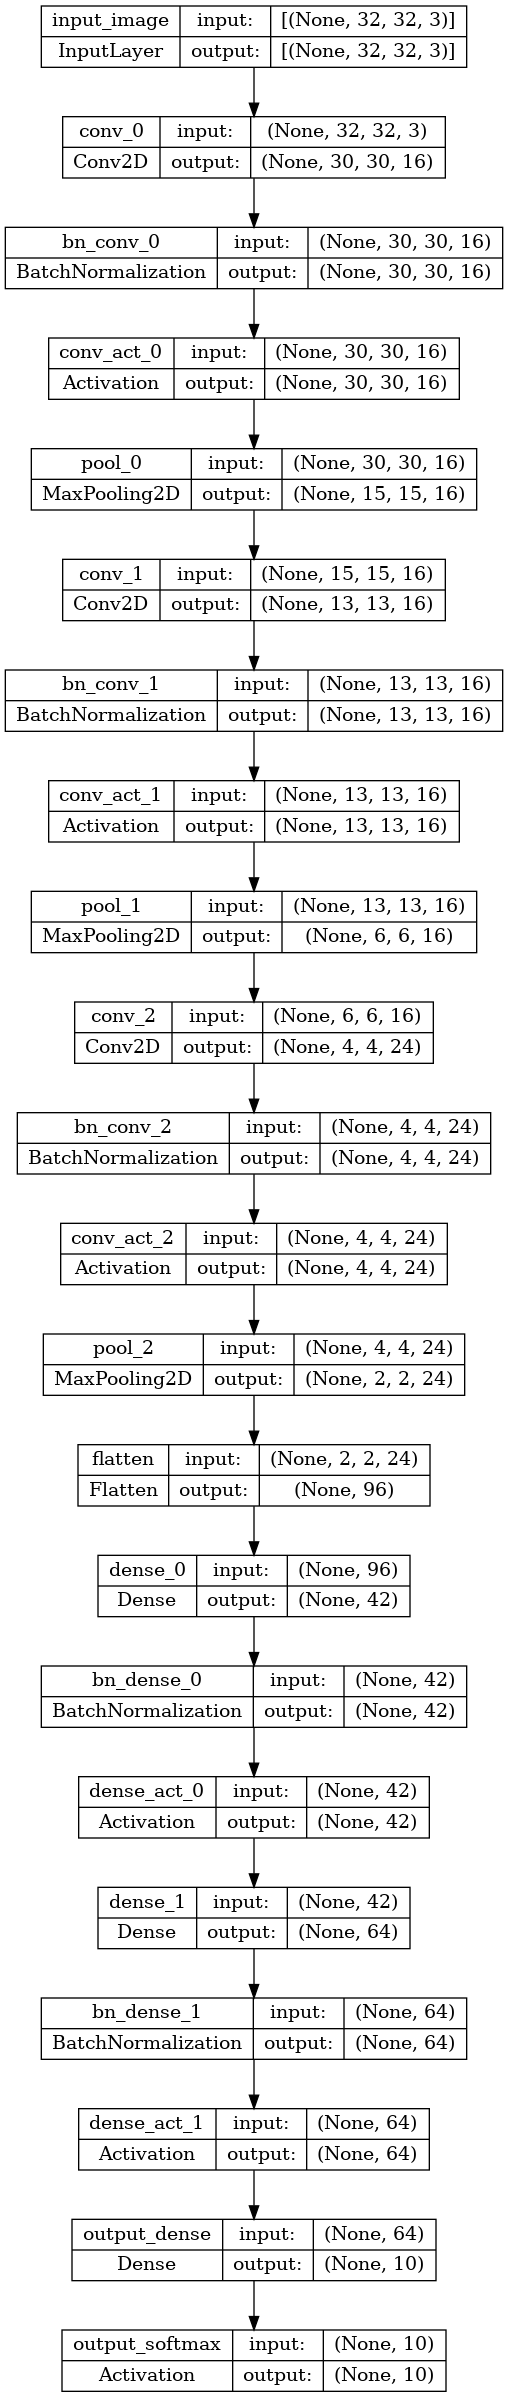

In [6]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

filters_per_conv_layer = [16, 16, 24]
neurons_per_dense_layer = [42, 64]

x = x_in = Input(input_shape, name='input_image')

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding convolutional block {} with N={} filters').format(i, f))
    x = Conv2D(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=False,
        name='conv_{}'.format(i),
    )(x)
    x = BatchNormalization(name='bn_conv_{}'.format(i))(x)
    x = Activation('relu', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding dense block {} with N={} neurons').format(i, n))
    x = Dense(n, kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), name='dense_%i' % i, use_bias=False)(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = Activation('relu', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)

model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()
plot_model(model, show_shapes=True, show_layer_names=True)

In [7]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name, layersize))  # 0 = weights, 1 = biases
        if layersize > 4096:  # assuming that shape[0] is batch, i.e., 'None'
            print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name, layersize))

conv_0: 432
conv_1: 2304
conv_2: 3456
dense_0: 4032
dense_1: 2688
output_dense: 640


In [8]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks, pruning_schedule

NSTEPS = int(train_size * 0.9) // batch_size  # 90% train, 10% validation in 10-fold cross validation
print('Number of training steps per epoch is {}'.format(NSTEPS))


# Prune all convolutional and dense layers gradually from 0 to 50% sparsity every 2 epochs,
# ending by the 10th epoch
def pruneFunction(layer):
    pruning_params = {
        # 'pruning_schedule': sparsity.PolynomialDecay(
        #     initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        # )
        "pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)
    }
    if isinstance(layer, tf.keras.layers.Conv2D):
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'output_dense':
        return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return 

# def pruneFunction2(model):
#     pruning_params = {
#         # 'pruning_schedule': sparsity.PolynomialDecay(
#         #     initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
#         # )
#         "pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)
#     }
    
#     model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    

# model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)

Number of training steps per epoch is 64


## Train baseline

In [9]:
def train_model(model, model_name, prune, load=True):
    tf_callbacks_no_pruning = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ]
    
    tf_callbacks_pruning = [
        tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        pruning_callbacks.UpdatePruningStep(),
    ]

    pruning_params = {
        # 'pruning_schedule': sparsity.PolynomialDecay(
        #     initial_sparsity=0.0, final_sparsity=0.50, begin_step=NSTEPS * 2, end_step=NSTEPS * 10, frequency=NSTEPS
        # )
        'pruning_schedule': sparsity.PolynomialDecay(
            initial_sparsity=0.5, final_sparsity=0.80, begin_step=0, end_step=NSTEPS * 2
        )
        #"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)
    }

    callbacks = tf_callbacks_pruning if prune else tf_callbacks_no_pruning
    
    train = not load
    n_epochs = 30

    LOSS = tf.keras.losses.CategoricalCrossentropy()
    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=3e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    
    if train:
        # if prune:
        #     model = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
        #     print(model.summary())
        
        model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
    
        start = time.time()
        model.fit(train_data, epochs=n_epochs, validation_data=val_data, callbacks=callbacks)
        end = time.time()
    
        print('It took {} minutes to train Keras model'.format((end - start) / 60.0))
        # if prune:
        #     model = tfmot.sparsity.keras.strip_pruning(model)
        #     model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

        if prune:
            model_for_export = tfmot.sparsity.keras.strip_pruning(model)
        else:
            model_for_export = model
            
        tf.keras.models.save_model(model_for_export, f'{model_name}.h5', include_optimizer=False)
    
    else:
        from qkeras.utils import _add_supported_quantized_objects
        from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
    
        co = {}
        _add_supported_quantized_objects(co)
        if prune:
            co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
        if prune:
            model = tf.keras.models.load_model(f'{model_name}.h5', custom_objects=co, compile=False)
            model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])
        else:
            model = tf.keras.models.load_model(f'{model_name}.h5', custom_objects=co)


    return model

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def visualize_roc(model, model_name, ax=None):
    predict = model.predict(X_test)
    test_score = model.evaluate(X_test, Y_test)
    
    labels = ['%i' % nr for nr in range(0, n_classes)]  # If you want to look at all the labels
    # labels = ['0','1','9'] # Look at only a few labels, here for digits 0, 1 and 9
    # print('Plotting ROC for labels {}'.format(labels))
    
    df = pd.DataFrame()
    df_q = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    fpr_q = {}
    tpr_q = {}
    auc1_q = {}
    # %matplotlib inline
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', '#fddbc7', '#d1e5f0', '#92c5de', '#4393c3', '#2166ac', '#053061']
    if ax == None:
        _, ax = plt.subplots(figsize=(10, 10))
        
    for i, label in enumerate(labels):
        df[label] = Y_test[:, int(label)]
        df[label + '_pred'] = predict[:, int(label)]
        fpr[label], tpr[label], threshold = metrics.roc_curve(df[label], df[label + '_pred'])
        auc1[label] = metrics.auc(fpr[label], tpr[label])
    
        # df_q[label] = Y_test[:, int(label)]
        # df_q[label + '_pred'] = predict_qkeras[:, int(label)]
        # fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label], df_q[label + '_pred'])
        # auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])
    
        ax.plot(
            fpr[label],
            tpr[label],
            label=r'{}, AUC = {:.1f}%'.format(label, auc1[label] * 100),
            linewidth=1.5,
            c=colors[i],
            linestyle='solid',
        )
        # plt.plot(fpr_q[label], tpr_q[label], linewidth=1.5, c=colors[i], linestyle='dotted')
    
    ax.semilogx()
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate")
    ax.set_xlim(0.01, 1.0)
    ax.set_ylim(0.5, 1.1)
    ax.legend(loc='lower right')
        # wrap=True,
        # 1,
        # 1,
    ax.text(
        10**-2 + 0.01/3,
        1.05,
        r'{}. Accuracy = {:.1f}%'.format(model_name, test_score[1] * 100),
        wrap=True,
        ha='left',
        va='center',
    )
    from matplotlib.lines import Line2D
    
    lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
    from matplotlib.legend import Legend
    
    leg = Legend(ax, lines, labels=[model_name,], loc='lower right', frameon=False)
    # ax.add_artist(leg)

In [11]:
def visualize_sparsity(model, plot_title):
    allWeightsByLayer = {}
    for layer in model.layers:
        if (layer._name).find("batch") != -1 or len(layer.get_weights()) < 1:
            continue
        weights = layer.weights[0].numpy().flatten()
        allWeightsByLayer[layer._name] = weights
        print('Layer {}: % of zeros = {}'.format(layer._name, np.sum(weights == 0) / np.size(weights)))

    labelsW = []
    histosW = []

    for key in reversed(sorted(allWeightsByLayer.keys())):
        labelsW.append(key)
        histosW.append(allWeightsByLayer[key])

    fig = plt.figure(figsize=(10, 10))
    bins = np.linspace(-1.5, 1.5, 50)
    plt.hist(histosW, bins, histtype='stepfilled', stacked=True, label=labelsW, edgecolor='black')
    # plt.yscale('log')
    plt.legend(frameon=False, loc='upper left')
    plt.ylabel('Number of Weights')
    plt.xlabel('Weights')
    plt.figtext(0.2, 0.38, plot_title, wrap=True, horizontalalignment='left', verticalalignment='center')

In [12]:
model = train_model(model, "cnn_model", True)

1/1 [==============================] - 0s 148ms/step
Predicted 6


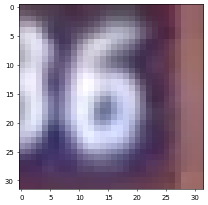

In [13]:
plt.rcParams['figure.dpi'] = 50
plt.rcParams['savefig.dpi'] = 50

test_image_no = 6

plt.imshow(X_test[test_image_no])
print(f'Predicted {np.argmax(model.predict(np.reshape(X_test[test_image_no], (1, 32, 32, 3))))}')

814/814 [==============================] - 3s 3ms/step - loss: 0.4504 - accuracy: 0.8972


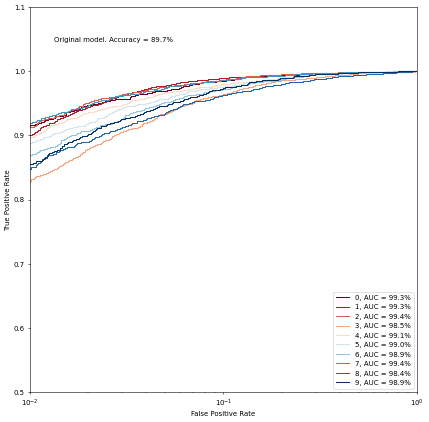

In [14]:
visualize_roc(model, 'Original model')
# visualize_sparsity(model, 'Original model')

In [15]:
#model_pruned = tf.keras.models.clone_model(model, clone_function=pruneFunction)
#model_pruned = train_model(model_pruned, "cnn_model_pruned", True)
#model_pruned = tf.keras.models.clone_model(model)
#model_pruned = train_model(model_pruned, "cnn_model_pruned", True)
# pruning_params = {
#      "pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=2000, frequency=100)
# }
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(
        initial_sparsity=0.5, final_sparsity=0.80, begin_step=0, end_step=NSTEPS * 2
    )
}
model_pruned = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
model_pruned = train_model(model_pruned, "cnn_model_pruned", True)

814/814 [==============================] - 3s 3ms/step - loss: 0.4587 - accuracy: 0.8759
Layer conv_0: % of zeros = 0.7962962962962963
Layer bn_conv_0: % of zeros = 0.0
Layer conv_1: % of zeros = 0.796875
Layer bn_conv_1: % of zeros = 0.0
Layer conv_2: % of zeros = 0.796875
Layer bn_conv_2: % of zeros = 0.0
Layer dense_0: % of zeros = 0.796875
Layer bn_dense_0: % of zeros = 0.0
Layer dense_1: % of zeros = 0.796875
Layer bn_dense_1: % of zeros = 0.0
Layer output_dense: % of zeros = 0.796875


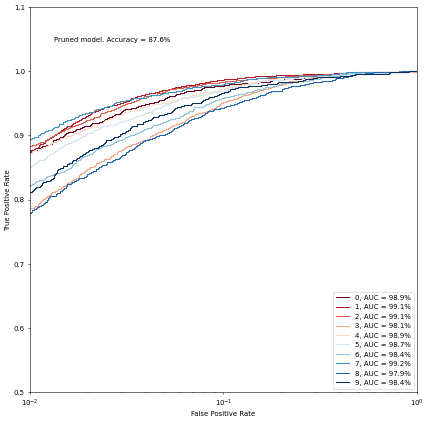

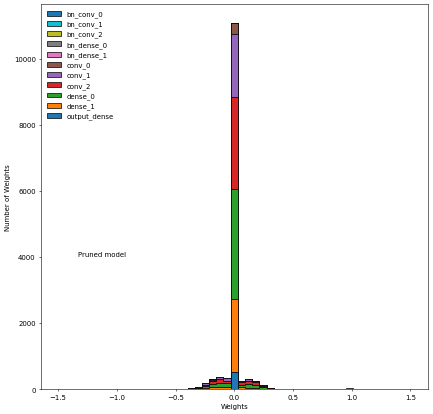

In [16]:
visualize_roc(model_pruned, 'Pruned model')
visualize_sparsity(model_pruned, 'Pruned model')

In [17]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

use_qmodel = False
x = x_in = Input(shape=input_shape, name='input_image')

for i, f in enumerate(filters_per_conv_layer):
    print(('Adding fused QConv+BN block {} with N={} filters').format(i, f))
    x = QConv2DBatchnorm(
        int(f),
        kernel_size=(3, 3),
        strides=(1, 1),
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        bias_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        use_bias=True,
        name='fused_convbn_{}'.format(i),
    )(x)
    x = QActivation('quantized_relu(6)', name='conv_act_%i' % i)(x)
    x = MaxPooling2D(pool_size=(2, 2), name='pool_{}'.format(i))(x)
x = Flatten()(x)

for i, n in enumerate(neurons_per_dense_layer):
    print(('Adding QDense block {} with N={} neurons').format(i, n))
    x = QDense(
        n,
        kernel_quantizer="quantized_bits(6,0,alpha=1)",
        kernel_initializer='lecun_uniform',
        kernel_regularizer=l1(0.0001),
        name='dense_%i' % i,
        use_bias=False,
    )(x)
    x = BatchNormalization(name='bn_dense_{}'.format(i))(x)
    x = QActivation('quantized_relu(6)', name='dense_act_%i' % i)(x)
x = Dense(int(n_classes), name='output_dense')(x)
x_out = Activation('softmax', name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()

Adding fused QConv+BN block 0 with N=16 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding fused QConv+BN block 2 with N=24 filters
Adding QDense block 0 with N=42 neurons
Adding QDense block 1 with N=64 neurons
Model: "qkeras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 fused_convbn_0 (QConv2DBat  (None, 30, 30, 16)        513       
 chnorm)                                                         
                                                                 
 conv_act_0 (QActivation)    (None, 30, 30, 16)        0         
                                                                 
 pool_0 (MaxPooling2D)       (None, 15, 15, 16)        0         
                                                                 
 fused_convbn_1 (QConv2DBat  (None

In [18]:
# Print the quantized layers
from qkeras.autoqkeras.utils import print_qmodel_summary

print_qmodel_summary(qmodel)

Using TensorFlow backend
fused_convbn_0       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_0           quantized_relu(6)
fused_convbn_1       f=16 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_1           quantized_relu(6)
fused_convbn_2       f=24 quantized_bits(6,0,0,alpha=1) quantized_bits(6,0,0,alpha=1) 
conv_act_2           quantized_relu(6)
dense_0              u=42 quantized_bits(6,0,0,alpha=1) 
bn_dense_0           is normal keras bn layer
dense_act_0          quantized_relu(6)
dense_1              u=64 quantized_bits(6,0,0,alpha=1) 
bn_dense_1           is normal keras bn layer
dense_act_1          quantized_relu(6)



In [19]:
if use_qmodel:
    qmodel = train_model(qmodel, 'cnn_qmodel', True)

In [20]:
if use_qmodel:
    visualize_roc(qmodel, "Quantized model")
    visualize_sparsity(qmodel, "Quantized model")

In [21]:
if use_qmodel:
    qmodel_pruned = tfmot.sparsity.keras.prune_low_magnitude(qmodel, **pruning_params)
    qmodel_pruned = train_model(qmodel_pruned, 'cnn_qmodel_pruned', True)

In [22]:
if use_qmodel:
    visualize_roc(qmodel_pruned, 'Quantized and pruned model')
    visualize_sparsity(qmodel_pruned, "Quantized and prunedmodel")

In [23]:
def representative_dataset_cb():
    for x, y in zip(X_test, Y_test):
        yield {
            'input_image': x.reshape( (1,)+x.shape),
            'output_softmax': y
        }

In [24]:
models = {
    'cnn_not_optimised': {
        'title': 'Not optimised CNN',
        'model': model
    },
    'cnn_pruned': {
        'title': 'Pruned CNN',
        'model': model_pruned
    },
    # Due to some incompatibility with ftlite-micro, xnnpack and gpu runs, it will not be used int this work
    # 'cnn_quantized': {
    #     'title': 'Quantised CNN',
    #     'model': qmodel
    # },
    # 'cnn_quantized_pruned': {
    #     'title': 'Quantised andpruned CNN',
    #     'model': qmodel_pruned
    # }
}
# To avoid dynamic ranges in the resulting tflite models (which is not supported by the xnnpack and tflite micro), 
# I put representative dataset calback everywhere
# https://www.tensorflow.org/lite/performance/post_training_integer_quant

def build_no_opt_converter(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.representative_dataset = representative_dataset_cb
    return converter.convert()

def build_default_opt_converter(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_cb
    return converter.convert()

# def build_post_training_float16_quant_opt_converter(model):
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     # https://www.tensorflow.org/api_docs/python/tf/lite/Optimize
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]
#     converter.target_spec.supported_types = [tf.float16]
#     converter.representative_dataset = representative_dataset_cb
#     return converter.convert()

def build_post_training_int8_quant_opt_converter(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)

    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_cb
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8  # or tf.uint8
    converter.inference_output_type = tf.int8  # or tf.uint8

    return converter.convert()

# converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]


def build_post_training_16bit_activations_8bit_weigths(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_dataset_cb
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
    converter.inference_input_type = tf.int16  # or tf.uint8
    converter.inference_output_type = tf.int16  # or tf.uint8
    return converter.convert()


tflite_optimizations = {
    'no_opt': {
        'title': 'No post training optimization',
        'build_converter': build_no_opt_converter
    },
    'default_opt': {
        'title': 'Default tflite post training optimization',
        'build_converter': build_default_opt_converter
    },
    'int8_quant': {
        'title': 'Integer 8 bit post training quantization',
        'build_converter': build_post_training_int8_quant_opt_converter
    }
}
    
    # For some reason it generates hybrid model 
    # 'int16_activations_int8_weights': {
    #     'title': 'Integer only: 16-bit activations with 8-bit weights',
    #     'build_converter': build_post_training_16bit_activations_8bit_weigths
    # },

    # Float16 quantisation is not supported by tflite micro 
    # Node  (number 0) failed to invoke with status 1
    # Input FLOAT16, output FLOAT32 not supported.
    # 'float16_quant': { 
    #     'title': 'Float 16 bit post training quantization',
    #     'build_converter': build_post_training_float16_quant_opt_converter
    # },

excludes = (
    ('cnn_quantized', 'int8_quant'),
    ('cnn_quantized_pruned', 'int8_quant')
)

In [25]:
# !rm *.h *.tflite

In [26]:
import os

tf.experimental.numpy.experimental_enable_numpy_behavior()

tflite_models = {}

for model_name, keras_model in models.items():
    for opt_name, optimization in tflite_optimizations.items():
        fully_qualified_model_name = f'{model_name}-{opt_name}'
        model_path = f'{fully_qualified_model_name}.tflite'
        if ((model_name, opt_name) in excludes) or os.path.exists(model_path):
            continue
            
        print(f'Processing {keras_model["title"]} with {optimization["title"]} ({model_path})')
        
        tflite_model = optimization['build_converter'](keras_model['model'])

        tflite_models[fully_qualified_model_name] = tflite_model
        
        with open(model_path, 'wb') as f:
            f.write(tflite_model)
        

In [27]:
import subprocess
for model in tflite_models.keys():
    process = subprocess.run(f'xxd -i {model}.tflite'.split(), capture_output=True, text=True)
    if process.returncode != 0:
        print(f'Error with {model}')
    else:
        with open(f'{model}_tflite.h', 'w') as f:
            f.write(f'#ifndef {model.upper().replace("-", "_")}_TFLITE_H\n')
            f.write(f'#define {model.upper().replace("-", "_")}_TFLITE_H\n\n')

            f.write(process.stdout)
            f.write('\n\n')
            
            f.write('#endif\n')

In [28]:
import numpy as np
import tensorflow as tf
import glob

class TFLiteAsKeras:
    def __init__(self, model_path, batch_size=1):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.batch_size = batch_size
        self.interpreter.resize_tensor_input(0, (batch_size, *self.interpreter.get_input_details()[0]['shape'][1:]))
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()

    def _preprocess_input(self, input_data):
        # Add any input preprocessing if needed
        # input_data = np.array(input_data, dtype=np.float32)
        return input_data

    def _postprocess_output(self, output_data):
        # Add any output postprocessing if needed
        return output_data

    def predict(self, input_data):
        input_data = self._preprocess_input(input_data)

        # Set input tensor
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)

        # Run inference
        self.interpreter.invoke()

        # Get the output tensor
        output_data = self.interpreter.get_tensor(self.output_details[0]['index'])

        output_data = self._postprocess_output(output_data)

        return output_data

    def evaluate(self, input_data, ground_truth_labels):
        input_data = self._preprocess_input(input_data)
        ground_truth_labels = np.array(ground_truth_labels, dtype=np.int32)

        
        # Set input tensor
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)

        # Run inference
        self.interpreter.invoke()

        # Get the output tensor
        output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
        output_data = self._postprocess_output(output_data)

        # Evaluate predictions
        # accuracy = np.mean(np.argmax(output_data, axis=1) == ground_truth_labels)
        # print(ground_truth_labels.shape, output_data.shape, np.argmax(output_data, axis=1).shape)
        accuracy = np.mean(np.argmax(output_data, axis=1) == np.argmax(ground_truth_labels, axis=1))

        loss = 0
        
        return loss, accuracy

In [29]:
tflite_model_paths = [
    'cnn_not_optimised-no_opt.tflite',
    'cnn_not_optimised-default_opt.tflite',
    'cnn_not_optimised-int8_quant.tflite',
    'cnn_pruned-no_opt.tflite',
    'cnn_pruned-default_opt.tflite',
    'cnn_pruned-int8_quant.tflite'
]

tflite_model_descriptions = [
    'no optimization',
    '32-bit integer quantization', 
    '8-bit integer quantization',
    'pruning',
    '32-bit integer quantization + pruning',
    '8-bit integer quantization + pruning'
]

cnn_not_optimised-no_opt.tflite


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


cnn_not_optimised-default_opt.tflite
cnn_not_optimised-int8_quant.tflite
cnn_pruned-no_opt.tflite
cnn_pruned-default_opt.tflite
cnn_pruned-int8_quant.tflite


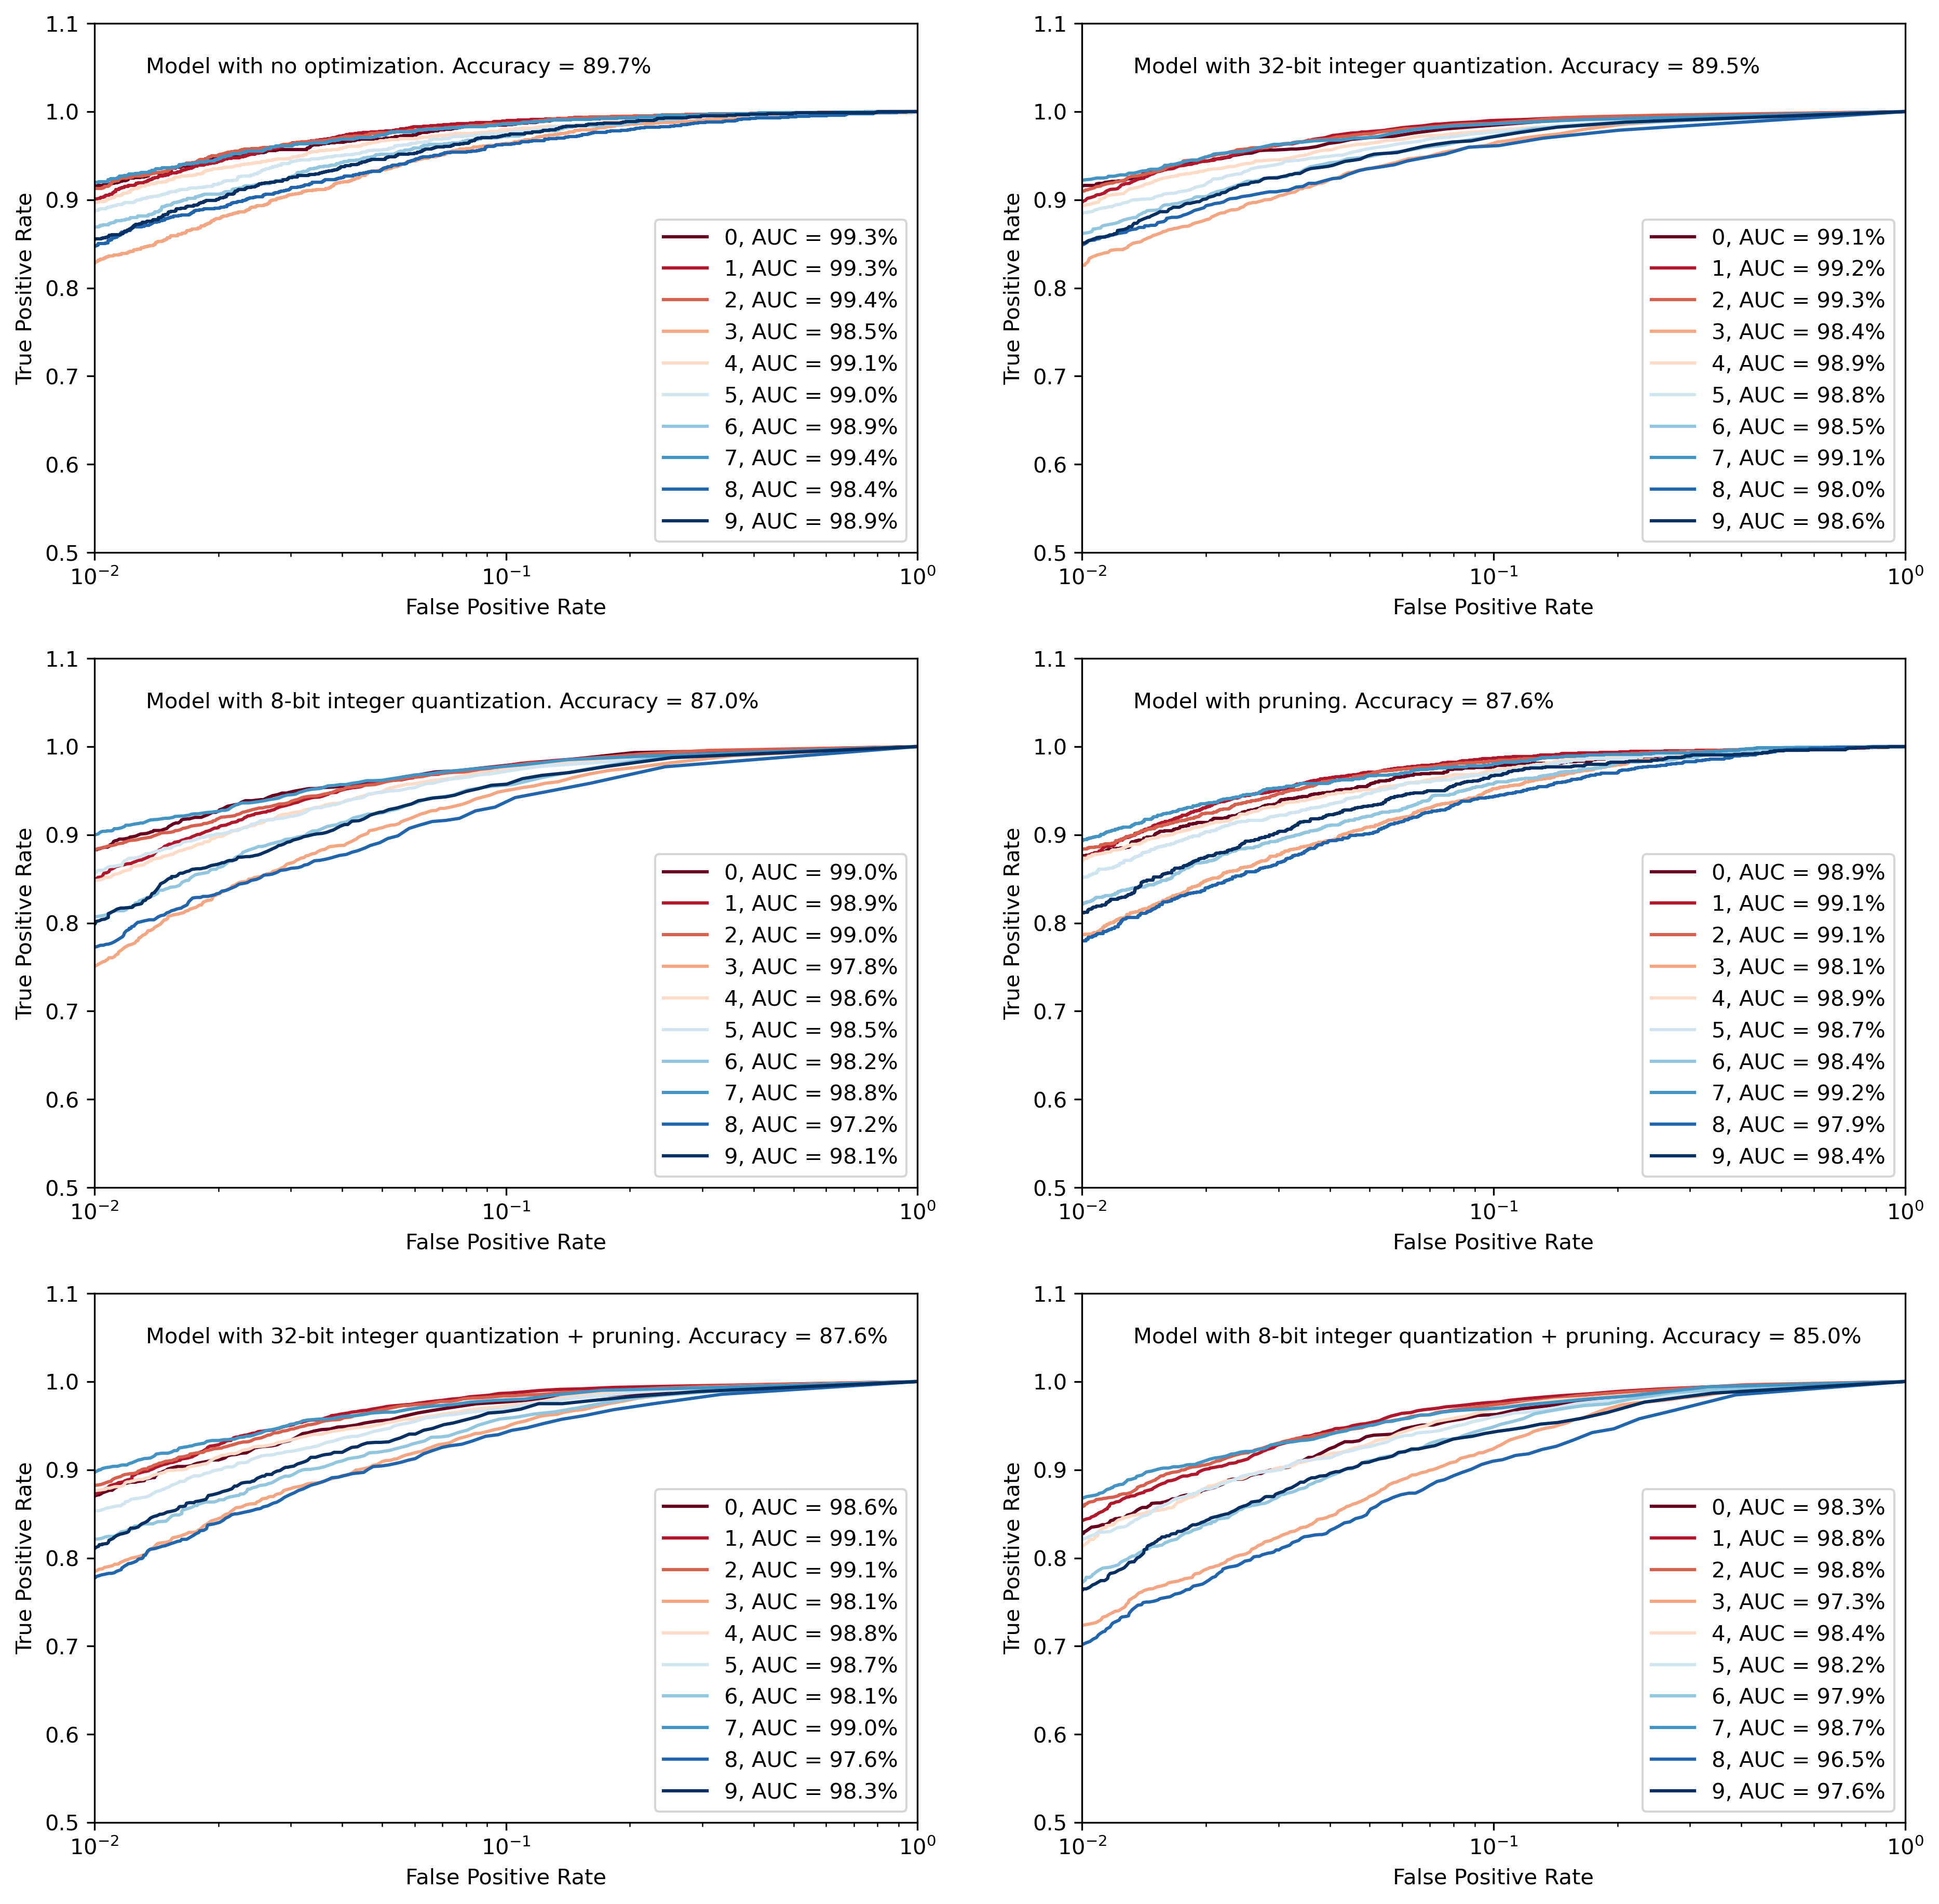

In [30]:
int8_models = glob.glob('*int8*.tflite')

def int8_input_data_conversion(scales=0.00392157, offset=-128):
    def f(data):
        max_value = np.max(data.numpy())
        return (data.numpy() * 255 / scales + offset).astype(np.int8)

    return f



def render_plots(ncols=2, figsize=(20, 20)):
    nrows = int(np.ceil(len(tflite_model_paths) / ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    
    for n, (testing_model_path, testing_model_desc) in enumerate(zip(tflite_model_paths, tflite_model_descriptions)):
        print(testing_model_path)
    
        row = n//ncols
        col = n % ncols
        
        testing_model = TFLiteAsKeras(testing_model_path, X_test.shape[0])
        if testing_model_path in int8_models:
            scales = testing_model.input_details[0]['quantization'][0]
            offset = testing_model.input_details[0]['quantization'][1]
            testing_model._preprocess_input = int8_input_data_conversion(scales, offset)
    
        visualize_roc(testing_model, f'Model with {testing_model_desc}', ax[row, col])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


render_plots(2, (15, 15))
# render_plots(3, (20,20))


In [31]:
import json
model_stats = {}

for p in tflite_model_paths:
    model = TFLiteAsKeras(p, X_test.shape[0])

    if p in int8_models:
            scales = model.input_details[0]['quantization'][0]
            offset = model.input_details[0]['quantization'][1]
            model._preprocess_input = int8_input_data_conversion(scales, offset)
    
    _, precision = model.evaluate(X_test, Y_test)
    model_stats[p] = precision

with open('models_stats.json', 'w') as f:
    json.dump(model_stats, f)
!cat models_stats.json

{"cnn_not_optimised-no_opt.tflite": 0.8971650276582668, "cnn_not_optimised-default_opt.tflite": 0.8954363859864782, "cnn_not_optimised-int8_quant.tflite": 0.8700061462814997, "cnn_pruned-no_opt.tflite": 0.8759219422249539, "cnn_pruned-default_opt.tflite": 0.8756146281499693, "cnn_pruned-int8_quant.tflite": 0.85029963122311}

In [32]:
# def time_measure(f, time_cb, *args, **kwargs):
#     execution_time = time.process_time()
#     result = f(*args, **kwargs)
#     execution_time = time.time() - execution_time
    
#     time_cb(execution_time)
    
#     return result

# def model_avg_execution_time(model):
#     interpreter = tf.lite.Interpreter(model_content=model)
#     interpreter.allocate_tensors()

#     execution_times = []
#     for data in representative_dataset_cb():
#         dinput = interpreter.get_input_details()
#         doutput = interpreter.get_output_details()
        
#         interpreter.set_tensor( dinput[0]['index'], data['input_image'] )
#         def invoke():
#             for i in range(1000):
#                 interpreter.invoke
        
#         time_measure(invoke, lambda t: execution_times.append(t/1000))
#         yy = interpreter.get_tensor( doutput[0]['index'] ) # access the one element, and get the 'index'
#         y = yy[0] # fix output shape
#         cat_act = np.argmax(data["output_softmax"])
#         cat_pred = np.argmax(y)
#         # print(f'Predicted {cat_pred}, expected {cat_act}')
#     return np.average(execution_times)

In [33]:
# https://www.tensorflow.org/lite/performance/measurement
!wget https://storage.googleapis.com/tensorflow-nightly-public/prod/tensorflow/release/lite/tools/nightly/latest/linux_x86-64_benchmark_model_performance_options
!chmod u+x linux_x86-64_benchmark_model_performance_options

--2024-02-27 21:08:56--  https://storage.googleapis.com/tensorflow-nightly-public/prod/tensorflow/release/lite/tools/nightly/latest/linux_x86-64_benchmark_model_performance_options
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.39.27, 142.251.39.59, 142.251.39.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.39.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4954176 (4.7M) [application/octet-stream]
Saving to: ‘linux_x86-64_benchmark_model_performance_options.6’

linux_x86-64_benchm 100%[===================>]   4.72M  5.22MB/s    in 0.9s    

2024-02-27 21:08:58 (5.22 MB/s) - ‘linux_x86-64_benchmark_model_performance_options.6’ saved [4954176/4954176]



In [34]:
import subprocess

def parse_model_bench_output(output):
    result = output.split('==============Summary of All Runs w/ Different Performance Options==============\n')[1].splitlines()
    result = [line.strip('INFO: ') for line in result]
    result = {line.split(':')[0]: line.split(':')[1].strip().split() for line in result}
    result = {key : {value.split('=')[0]: float(value.split('=')[1]) for value in tuple_value}
                    for key, tuple_value in result.items()}
    return result

In [35]:
import os

model_runtime_metrics = {}
# ALSO! Include model size here!
for model_name in tflite_models.keys():
    model_path = os.path.abspath(f'{model_name}.tflite')
    model_size = os.path.getsize(f'{model_name}.tflite')
    command = f'./linux_x86-64_benchmark_model_performance_options --graph={model_path}'
    
    print(f'Benchmarking {model_name}...')
    result = subprocess.run(command.split(), capture_output=True, text=True)
    
    error = 'ERROR:' in result.stderr
    if (error): 
        print(f'Error occured while benchmarking {model_name}. {result.stderr}')
    else:
        print('...Done!')
        model_runtime_metrics[model_name] = parse_model_bench_output(result.stdout)
        for key in model_runtime_metrics[model_name].keys():
            model_runtime_metrics[model_name][key]['model_size_uncompressed'] = model_size
        # model_runtime_metrics[model_name]['model_size_uncompressed'] = model_size

In [36]:
import os
import glob

model_runtime_metrics_esp = {}
# ALSO! Include model size here!
for model_log in glob.glob('power_data/*.log'):
    print(f'Processing {model_log}...') 
    model_name = model_log.replace('.log', '')
    with open(model_log) as f:
        model_runtime_metrics_esp[model_name] = parse_model_bench_output(f.read())
        # for key in model_runtime_metrics[model_name].keys():
        #     model_runtime_metrics[model_name][key]['model_size_uncompressed'] = model_size


Processing power_data/cnn_pruned_no_opt_tflite.log...
Processing power_data/cnn_pruned_default_opt_tflite.log...
Processing power_data/cnn_pruned_int8_quant_tflite.log...
Processing power_data/cnn_not_optimised_int8_quant_tflite.log...
Processing power_data/cnn_not_optimised_default_opt_tflite.log...
Processing power_data/cnn_not_optimised_no_opt_tflite.log...


In [37]:
from pandas import DataFrame as df

model_runtime_metrics_df = {key: df.from_dict(model_runtime_metrics[key]) for key in model_runtime_metrics.keys()}

In [38]:
from IPython.display import display, HTML

for model, stat in model_runtime_metrics_df.items():
    print(f'Model {model}...')
    display(HTML(stat.to_html()))

In [50]:
import matplotlib.pyplot as plt

def plot_metric(model_runtime_metrics, metric_name, metric_display_name=None):
    if metric_display_name == None:
        metric_display_name = metric_name
    
    models = tuple(model_runtime_metrics.keys())
    runtimes = tuple(model_runtime_metrics[models[0]].keys())

    fig = plt.figure(figsize=(10, 10))
    plt.yscale('log')
    plt.xticks(rotation=-45)
    plt.ylabel(metric_display_name)
    plt.xlabel('Model')
    
    for runtime in runtimes:
        metrics = []
        for model in models:
            metrics.append(model_runtime_metrics[model][runtime][metric_name])
        plt.plot(models, metrics, label=runtime, color='green')
    plt.legend()

In [40]:
plot_metric(model_runtime_metrics, 'avg')

IndexError: tuple index out of range

In [ ]:
plot_metric('first')

In [ ]:
plot_metric('model_size_uncompressed')

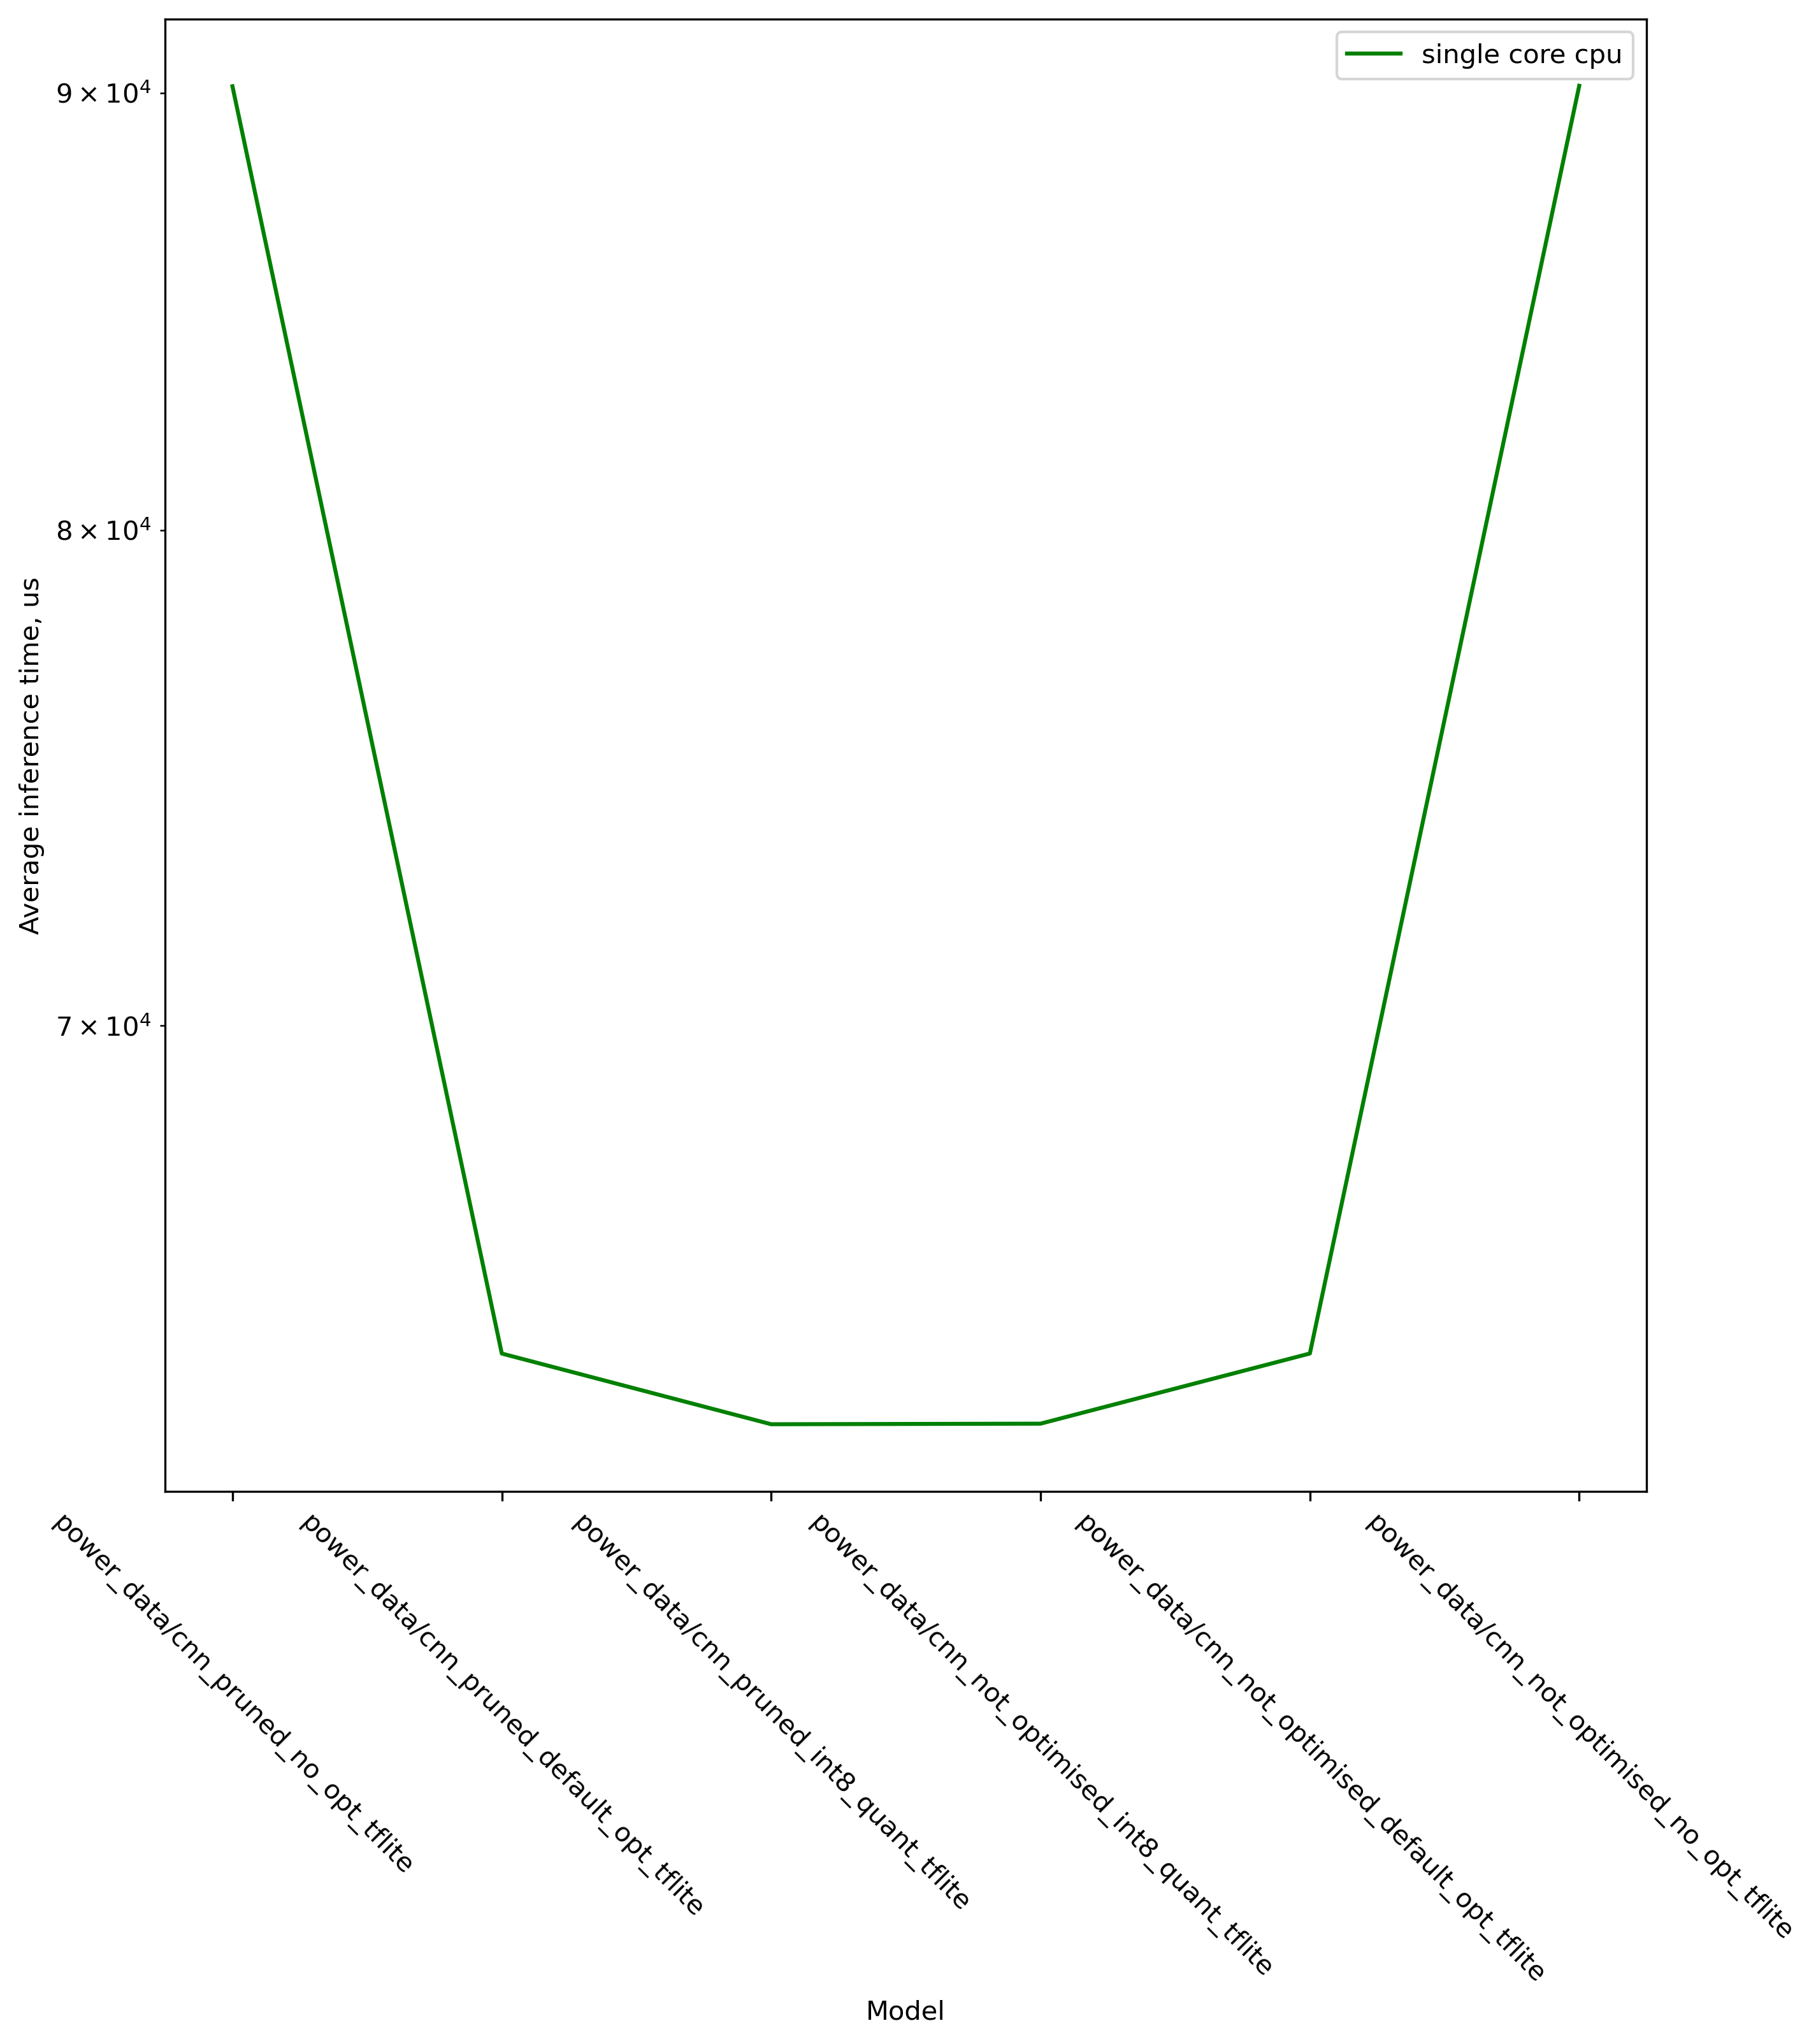

In [51]:
plot_metric(model_runtime_metrics_esp, 'avg', 'Average inference time, us')

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(qmodel_pruned)
# converter.optimizations = []
# qmodel_pruned_lite = converter.convert()
# with open("qmodel_pruned.tflite", "wb") as f:
#     f.write(qmodel_pruned_lite)

# interpreter = tf.lite.Interpreter(model_path="qmodel_pruned.tflite")
# interpreter.allocate_tensors()
# interpreter.get_tensor_details()

In [ ]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
# converter.representative_dataset = representative_dataset_cb
# model_lite_opdef = converter.convert()
# open("rps.opdef_int8.tflite", "wb").write(model_lite_opdef)

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.signal import lfilter

In [ ]:
def load_measurement_csv(path):
    
    dataframe = pd.read_csv(path)
    dataframe.loc[:,'Time(ns)'] /= 1000000
    dataframe.loc[:,'Vol(V)'] *= 1000

    # n = 15  # the larger n is, the smoother curve will be
    # b = [1.0 / n] * n
    # a = 1

    # dataframe.loc[:'Vol(V)'] = lfilter(b, a, dataframe.loc[:'Vol(V)'])
    
    return dataframe.rename(columns={'Time(ns)': 'Time(ms)', 'Vol(V)': 'Voltage(mV)'})

In [ ]:
schunt_value = 0.1
def convert_to_current(dataframe):
    dataframe = dataframe.copy()
    dataframe.loc[:,'Voltage(mV)'] /= schunt_value
    return dataframe.rename(columns={'Voltage(mV)': 'Current(mA)'})

In [ ]:
time_step_ns = 1000

def plot_voltage_masurement(data):
    # Take a 600ms of data
    n_steps = int(600000000 / time_step_ns)

    fig, ax = plt.subplots()
    data.head(n_steps).plot(x='Time(ms)', ax=ax, legend=False)
    ax.set_xlabel('Час (мс)')
    ax.set_ylabel('Напруга (мВ)')

In [ ]:
def plot_current_measurement(data):
    # Take a 600ms of data
    n_steps = int(600000000 / time_step_ns)

    fig, ax = plt.subplots()
    data.head(n_steps).plot(x='Time(ms)', ax=ax, legend=False)
    ax.set_xlabel('Час (мс)')
    ax.set_ylabel('Струм (мА)')

In [ ]:
measurement_voltage = load_measurement_csv('power_data/cnn_not_optimised_no_opt_tflite.csv')

In [ ]:
plot_voltage_masurement(measurement_voltage)

In [ ]:
measured_current = convert_to_current(measurement_voltage)

In [ ]:
plot_current_measurement(measured_current)